# Motor Vehicle Collisions

### Load the Workspace

In [1]:
import re
import datetime as dt
import time
from zipfile import ZipFile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook'

from wordcloud import WordCloud
import folium
from folium.plugins import HeatMap
from PIL import Image

import mysql.connector
import sqlalchemy
from sqlalchemy import create_engine

from scipy import stats
import statsmodels.formula.api as smf

### Load the Data

In [ ]:
with open("pass.txt") as f:
    file_info = f.readlines()

host = file_info[0].replace('\n', '')
user = file_info[1].replace('\n', '')
password = file_info[2]

In [ ]:
cnx = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database='nyc_motor_vehicle_collisions'
)

cursor = cnx.cursor()

The size of the database:

In [ ]:
string_query = """
select count(*)
from Vehicles v
         join Crashes c
              on v.COLLISION_ID = c.COLLISION_ID
         join Person p
              on p.COLLISION_ID = v.COLLISION_ID
"""

query = string_query
cursor.execute(query)

results = cursor.fetchall()
results

In [ ]:
string_query = """
select *
from Vehicles v
         join Crashes c
              on v.COLLISION_ID = c.COLLISION_ID
         join Person p
              on p.COLLISION_ID = v.COLLISION_ID
"""

query = string_query
cursor.execute(query)

results = cursor.fetchone()
len(results)

In [ ]:
results

The database has 9.5m rows and 75 columns. This will be too large to pull into python and will drain memory.

The purpose of this project is to provide recommendations to reduce the occurrence of accidents in the Borough with the most accidents from 2018 till present. 

To pull our data table into python, we'll filter out the data we need from sql and create a dataframe.

Let's find the Borough with the most accidents:

In [ ]:
cnx = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database='nyc_motor_vehicle_collisions'
)

cursor = cnx.cursor()

In [ ]:
string_query = """
select BOROUGH
from (
    select c.BOROUGH, COUNT(*) as acc_count
        from Vehicles v
            join Crashes c
                on v.COLLISION_ID = c.COLLISION_ID
            join Person p
                on p.COLLISION_ID = v.COLLISION_ID
        WHERE c.BOROUGH is not null
        GROUP BY c.BOROUGH
        ) as accident_counts
where acc_count = (select max(acc_count)
                   from (select c.BOROUGH, COUNT(*) as acc_count
                         from Vehicles v
                                  join Crashes c
                                       on v.COLLISION_ID = c.COLLISION_ID
                                  join Person p
                                       on p.COLLISION_ID = v.COLLISION_ID
                         WHERE c.BOROUGH is not null
                         GROUP BY c.BOROUGH) as Bac);
"""

query = string_query
cursor.execute(query)

results = cursor.fetchall()
results

The Borough with the most accidents is Brooklyn. The Borough with the most accidents since 2018 is also Brooklyn. We'll filter out that information and pass inot a dataframe.

In [ ]:
string_query = """
select BOROUGH
from (
         select c.BOROUGH, COUNT(*) as acc_count
         from Vehicles v
                  join Crashes c
                       on v.COLLISION_ID = c.COLLISION_ID
                  join Person p
                       on p.COLLISION_ID = v.COLLISION_ID
         WHERE c.BOROUGH is not null
           AND YEAR(str_to_date(v.CRASH_DATE, '%m/%d/%Y')) >= 2018
         GROUP BY c.BOROUGH
     ) as accident_counts
where acc_count = (select max(acc_count)
                   from (select c.BOROUGH, COUNT(*) as acc_count
                         from Vehicles v
                                  join Crashes c
                                       on v.COLLISION_ID = c.COLLISION_ID
                                  join Person p
                                       on p.COLLISION_ID = v.COLLISION_ID
                         WHERE c.BOROUGH is not null
                           AND YEAR(str_to_date(v.CRASH_DATE, '%m/%d/%Y')) >= 2018
                         GROUP BY c.BOROUGH) as Bac);
"""

query = string_query
cursor.execute(query)

results = cursor.fetchall()
results

In [ ]:
string_query = """
select v.COLLISION_ID, v.CRASH_DATE, v.CRASH_TIME,
       c.`ZIP CODE`, c.LATITUDE, c.LONGITUDE,
       p.PERSON_TYPE, p.PERSON_SEX, p.PERSON_INJURY,
       p.PERSON_AGE, v.VEHICLE_ID, v.STATE_REGISTRATION,
       v.VEHICLE_TYPE, c.`VEHICLE TYPE CODE 2`, v.VEHICLE_MAKE, v.VEHICLE_MODEL,
       v.VEHICLE_YEAR, v.TRAVEL_DIRECTION,
       v.VEHICLE_OCCUPANTS, v.DRIVER_SEX,
       v.DRIVER_LICENSE_STATUS, v.DRIVER_LICENSE_JURISDICTION,
       v.PRE_CRASH, v.POINT_OF_IMPACT, v.VEHICLE_DAMAGE,
       v.VEHICLE_DAMAGE_1, v.VEHICLE_DAMAGE_2, v.VEHICLE_DAMAGE_3,
       v.PUBLIC_PROPERTY_DAMAGE, v.PUBLIC_PROPERTY_DAMAGE_TYPE,
       v.CONTRIBUTING_FACTOR_1, v.CONTRIBUTING_FACTOR_2,
       c.`CONTRIBUTING FACTOR VEHICLE 1`,
       c.`CONTRIBUTING FACTOR VEHICLE 2`,
       c.`ON STREET NAME`, c.`OFF STREET NAME`,
       c.`CROSS STREET NAME`,
       c.`NUMBER OF PERSONS INJURED`, c.`NUMBER OF PERSONS KILLED`,
       c.`NUMBER OF PEDESTRIANS INJURED`, c.`NUMBER OF PEDESTRIANS KILLED`,
       c.`NUMBER OF CYCLIST INJURED`, c.`NUMBER OF CYCLIST KILLED`,
       c.`NUMBER OF MOTORIST INJURED`, c.`NUMBER OF MOTORIST KILLED`,
       p.EJECTION, p.EMOTIONAL_STATUS, p.BODILY_INJURY,
       p.POSITION_IN_VEHICLE, p.SAFETY_EQUIPMENT,
       p.COMPLAINT, p.PED_ROLE

from Vehicles v
         join Crashes c
              on v.COLLISION_ID = c.COLLISION_ID
         join Person p
              on p.COLLISION_ID = v.COLLISION_ID
where c.BOROUGH = (
    select BOROUGH
    from (
             select c.BOROUGH, COUNT(*) as acc_count
             from Vehicles v
                      join Crashes c
                           on v.COLLISION_ID = c.COLLISION_ID
                      join Person p
                           on p.COLLISION_ID = v.COLLISION_ID
             WHERE c.BOROUGH is not null
               AND YEAR(str_to_date(v.CRASH_DATE, '%m/%d/%Y')) >= 2018
             GROUP BY c.BOROUGH
         ) as accident_counts
    where acc_count = (select max(acc_count)
                       from (select c.BOROUGH, COUNT(*) as acc_count
                             from Vehicles v
                                      join Crashes c
                                           on v.COLLISION_ID = c.COLLISION_ID
                                      join Person p
                                           on p.COLLISION_ID = v.COLLISION_ID
                             WHERE c.BOROUGH is not null
                               AND YEAR(str_to_date(v.CRASH_DATE, '%m/%d/%Y')) >= 2018
                             GROUP BY c.BOROUGH) as Bac)
)
  and YEAR(str_to_date(v.CRASH_DATE, '%m/%d/%Y')) >= 2018
"""

In [ ]:
query = string_query
cursor.execute(query)

results = cursor.fetchall()

In [ ]:
columns = [
    'COLLISION_ID', 'CRASH_DATE', 'CRASH_TIME',
    'ZIP CODE', 'LATITUDE', 'LONGITUDE',
    'PERSON_TYPE', 'PERSON_SEX', 'PERSON_INJURY',
    'PERSON_AGE', 'VEHICLE_ID', 'STATE_REGISTRATION',
    'VEHICLE_TYPE', 'VEHICLE TYPE CODE 2', 
    'VEHICLE_MAKE', 'VEHICLE_MODEL', 'VEHICLE_YEAR', 
    'TRAVEL_DIRECTION', 'VEHICLE_OCCUPANTS', 
    'DRIVER_SEX', 'DRIVER_LICENSE_STATUS', 
    'DRIVER_LICENSE_JURISDICTION', 'PRE_CRASH', 
    'POINT_OF_IMPACT', 'VEHICLE_DAMAGE',
    'VEHICLE_DAMAGE_1', 'VEHICLE_DAMAGE_2', 
    'VEHICLE_DAMAGE_3', 'PUBLIC_PROPERTY_DAMAGE', 
    'PUBLIC_PROPERTY_DAMAGE_TYPE',
    'CONTRIBUTING_FACTOR_1', 'CONTRIBUTING_FACTOR_2',
    'CONTRIBUTING FACTOR VEHICLE 1',
    'CONTRIBUTING FACTOR VEHICLE 2',
    'ON STREET NAME', 'OFF STREET NAME',
    'CROSS STREET NAME', 'NUMBER OF PERSONS INJURED',
    'NUMBER OF PERSONS KILLED', 
    'NUMBER OF PEDESTRIANS INJURED', 
    'NUMBER OF PEDESTRIANS KILLED', 
    'NUMBER OF CYCLIST INJURED', 
    'NUMBER OF CYCLIST KILLED', 
    'NUMBER OF MOTORIST INJURED', 
    'NUMBER OF MOTORIST KILLED',
    'EJECTION', 'EMOTIONAL_STATUS', 'BODILY_INJURY',
    'POSITION_IN_VEHICLE', 'SAFETY_EQUIPMENT',
    'COMPLAINT', 'PED_ROLE'
]

columns = ["_".join(item.split(' ')).lower() for item in columns]

In [ ]:
df = pd.DataFrame(results, columns=columns)
df.head()

### Data Cleaning

1. Clean date and time features
2. Convert data types
3. Fill missing values

In [ ]:
df.info()

**Clean Feature Values & Convert datatypes**

In [ ]:
v_year_map = {
    9999:1999, 2077:2017, 2049:2019, 3017:2017, 2106:2016,
    2814:2014, 2087:2017, 2918:2018, 2027:2017, 2917:2017,
    2103:2013, 2041:2014, 2091:2019, 2209:2009, 2201:2021,
    2026:2016, 2914:2014, 2107:2017, 2915:2015, 2033:2013, 
    2040:2004, 2108:2018, 2206:2006, 2042:2014, 3011:2011, 
    2122:2022, 2025:2005, 2808:2008, 2086:2016, 2501:2015, 
    2912:2012, 2816:2016, 2104:2014, 2085:2015, 3005:2005, 
    2207:2007, 2714:2014, 2029:2019, 2204:2004, 3025:2015, 
    2911:2011, 2120:2020, 2919:2019, 2819:2019, 2109:2019,
    2089:2019, 2916:2016, 2719:2019, 2114:2014, 4992:2002, 
    2084:2004, 3016:2016, 2076:2016, 5005:2005, 2105:2015, 
    2102:2012, 3012:2012, 2024:2014, 3018:2018, 2997:2007, 
    2880:2000, 8008:2008, 2998:2008, 3026:2016, 2044:2014, 
    2995:2005, 4979:2019, 2993:2003, 2031:2013, 2815:2015, 
    3028:2018, 2208:2008, 2032:2012, 9019:2019, 3023:2023, 
    2818:2018, 2994:2004, 2050:2005, 3007:2007, 2092:2002, 
    2061:2016, 2913:2013, 2099:2019, 2082:2002, 2821:2021, 
    2088:2008, 2205:2015, 2047:2017, 2996:2006, 2045:2015,
    2028:2018, 2811:2011, 7398:2018, 3019:2019
    
}

In [ ]:
df = df.assign(
    crash_date=lambda x: pd.to_datetime(x.crash_date),
    crash_time=lambda x: x.crash_time.apply(
        lambda x: dt.datetime.strptime(x, "%H:%M").time()
        ),
    crash_datetime=lambda x: pd.to_datetime(
        x.crash_date.astype(str) + ' ' + x.crash_time.astype(str)
        ),
    vehicle_type=lambda x: np.where(
        x.vehicle_type.isna() & x.vehicle_type_code_2.notna(),
        x.vehicle_type_code_2,
        x.vehicle_type
    ), 
    vehicle_year=lambda x: x.vehicle_year.map(v_year_map).fillna(
        x.vehicle_year
        ),
    number_of_persons_injured=lambda x: x.number_of_persons_injured.fillna(0),
    number_of_persons_killed=lambda x: x.number_of_persons_killed.fillna(0),
    
    
).drop(
    columns=[
        'vehicle_model', 'public_property_damage_type',
        'vehicle_id', 
    ]
)

**Handle Duplicates & Missing Values**

In [ ]:
# Drop duplicate records:
drop_index = df.loc[df.duplicated(keep='first')].index
df = df.drop(index=drop_index)

# Drop records with missing values in 20 or more columns:
drop_index = df.loc[df.isnull().sum(axis=1) >= 20].index
df = df.drop(index=drop_index).reset_index(drop=True)

# Drop records with latitude and longitide as 0 or na:
drop_index = df.loc[df.longitude == 0].index
df = df.drop(index=drop_index).reset_index(drop=True)

drop_index = df.loc[df.longitude.isna()].index
df = df.drop(index=drop_index).reset_index(drop=True)

# Drop records with Vehicle Occupants Over 200 (outliers)
drop_index = df.loc[df.vehicle_occupants > 100].index
df = df.drop(index=drop_index).reset_index(drop=True)

df.info()

In [ ]:
df.to_csv('nyc_motor_vehicle_collisions.csv', index=False)

### Exploratory Analysis

We'll respond to the following questions:
1. Which location has the most accidents?
2. Which time has the most accidents?
3. Which day of the week has the most accidents?
4. How many victims on average per accident?
5. Registration Year for cars in accidents.
6. Reasons for accidents.
7. For vehicles from x year, what is the likelihood of accidents?
8. Which street corner / intersection is prone to accidents?
9. Gender split for Accidents.
10. What are the most contributing factors for accidents.
11. Which vehicles contribute the most to accidents.
12. Accident Trends over time
13. Injured vs Killed stats
14. Relationship between Complainant and person injured
15. Vehicle Damage vs Vehicle Make, Vehicle Type, Registration Year, Driver Sex, Point of Impact and Travel Direction
16. Driver Licence jurisdictions and accidents
17. Understanding these features - Ejection, Emotional status, Bodily injury, Position in vehicle, Safety equipment, Ped role
18. Provide recommendations to reduce occurrence of accidents

1. Which location has the most accidents?

We have a number of location based features:
* Longitude & Latitude
* on street name, off street name & cross street name

We'll begin by plotting a location based heatmap of accidents

In [29]:
df = pd.read_csv('nyc_motor_vehicle_collisions.csv').assign(
    crash_date=lambda x: pd.to_datetime(x.crash_date),
    crash_time=lambda x: x.crash_time.apply(
        lambda x: dt.datetime.strptime(x, "%H:%M:%S").time()
        ),
    crash_datetime=lambda x: pd.to_datetime(x.crash_datetime),
).map(lambda x: x.strip().title() if isinstance(x, str) else x)

df.head()


,collision_id,crash_date,crash_time,zip_code,latitude,longitude,person_type,person_sex,person_injury,person_age,...,number_of_motorist_injured,number_of_motorist_killed,ejection,emotional_status,bodily_injury,position_in_vehicle,safety_equipment,complaint,ped_role,crash_datetime
0,4136992,2019-05-21,22:50:00,11201.0,40.69754,-73.98312,Occupant,M,Unspecified,31.0,...,0,0,Not Ejected,Does Not Apply,Does Not Apply,"Front Passenger, If Two Or More Persons, Inclu...",Lap Belt & Harness,Does Not Apply,Passenger,2019-05-21 22:50:00
1,4136992,2019-05-21,22:50:00,11201.0,40.69754,-73.98312,Occupant,M,Unspecified,31.0,...,0,0,Not Ejected,Does Not Apply,Does Not Apply,"Front Passenger, If Two Or More Persons, Inclu...",Lap Belt & Harness,Does Not Apply,Passenger,2019-05-21 22:50:00
2,4136992,2019-05-21,22:50:00,11201.0,40.69754,-73.98312,Occupant,M,Unspecified,34.0,...,0,0,Not Ejected,Does Not Apply,Does Not Apply,Driver,Lap Belt,Does Not Apply,Driver,2019-05-21 22:50:00
3,4136992,2019-05-21,22:50:00,11201.0,40.69754,-73.98312,Occupant,M,Unspecified,34.0,...,0,0,Not Ejected,Does Not Apply,Does Not Apply,Driver,Lap Belt,Does Not Apply,Driver,2019-05-21 22:50:00
4,4136992,2019-05-21,22:50:00,11201.0,40.69754,-73.98312,Occupant,M,Unspecified,32.0,...,0,0,Not Ejected,Does Not Apply,Does Not Apply,Driver,Lap Belt & Harness,Does Not Apply,Driver,2019-05-21 22:50:00


Plotting Colors:

In [4]:
deep_colors = [
    '#4C72B0', '#55A868', '#C44E52',
    '#8172B2', '#CCB974', '#64B5CD'
]

Most accidents did not result in any injured person:

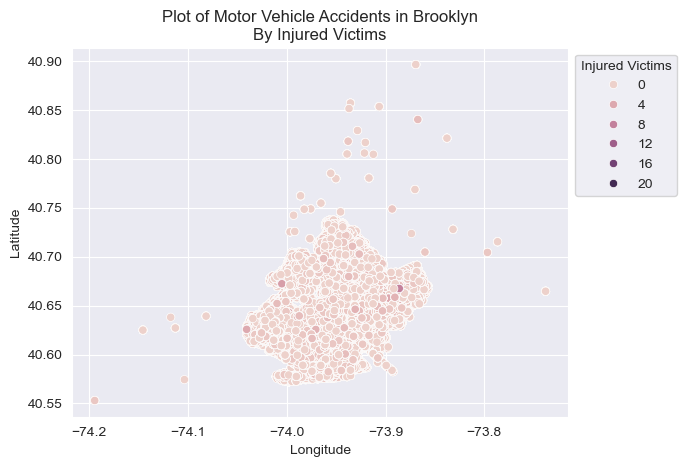

In [5]:
sns.set_palette([deep_colors[0]])
sns.set_style("darkgrid", {"grid.alpha": 0.2})

sns.scatterplot(
    data=df, x='longitude', y='latitude',
    hue='number_of_persons_injured'
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot of Motor Vehicle Accidents in Brooklyn\nBy Injured Victims')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Injured Victims")
plt.show()

Most accidents are from drivers who have licences:

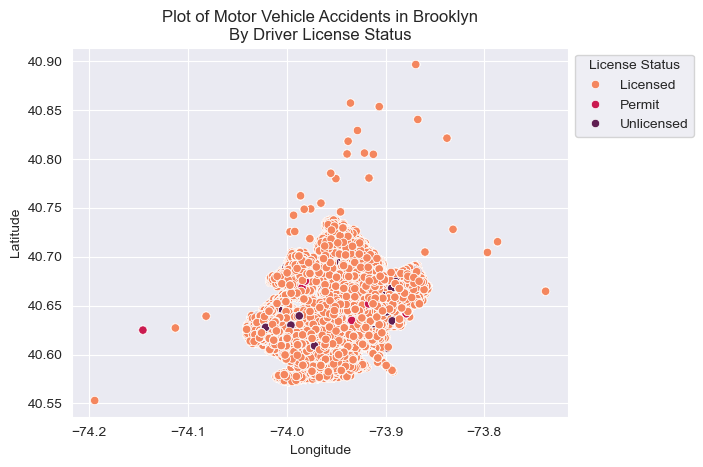

In [6]:
sns.set_palette([deep_colors[0]])
sns.set_style("darkgrid", {"grid.alpha": 0.2})

sns.scatterplot(
    data=df, x='longitude', y='latitude',
    hue='driver_license_status', palette='rocket_r'
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot of Motor Vehicle Accidents in Brooklyn\nBy Driver License Status')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="License Status")
plt.show()

Most accidents are by male drivers:

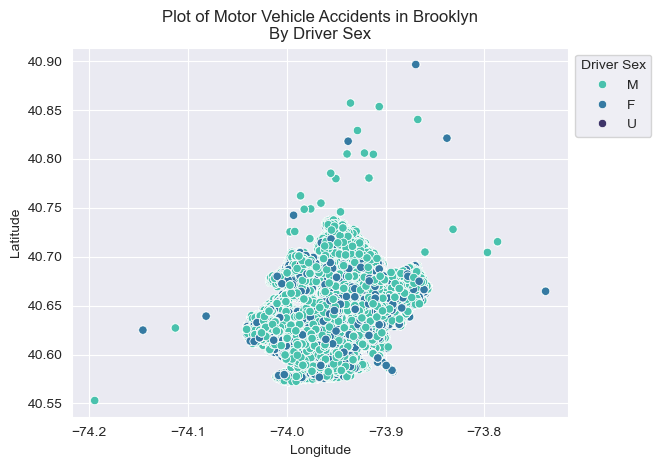

In [7]:
sns.set_palette([deep_colors[0]])
sns.set_style("darkgrid", {"grid.alpha": 0.2})

sns.scatterplot(
    data=df, x='longitude', y='latitude',
    hue='driver_sex', palette='mako_r',
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot of Motor Vehicle Accidents in Brooklyn\nBy Driver Sex')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Driver Sex")
plt.show()

**Most Popular Accident Intersections**

Most accidents occur around Flatbush Avenue Extension & Tillary Street. This intersection is home to 2 hotels and a park. It has a traffic light and a speed limit of 25mph. The intersection is featured in a legal article on [dangerous intersections](https://www.thebarnesfirm.com/tillary-st-flatbush-ave-dangerous-intersections/#:~:text=drivers%20at%20risk.-,Speed,at%20risk%20of%20an%20accident).

Located just off I-278, this intersection has a lot of traffic coming from and going to the high-speed interstate; but these are surface streets with a 25mph speed limit. With nearby parks and hotels, this intersection also features a lot of foot traffic, making it even more dangerous for pedestrians crossing the street.

Since much of the traffic here is coming from the Manhattan Bridge or Interstate 278, many of the vehicles here may be moving much faster than what the speed limit permits.

In [66]:
combined_set = list(
    set(df.loc[df.on_street_name.notna(), 'on_street_name'] + " - " +  df.loc[df.cross_street_name.notna(), 'cross_street_name'])
    )
combinations = df.groupby(['on_street_name', 'cross_street_name']
                          ).size().reset_index(name='Count')

most_common = combinations.sort_values(
    by='Count', ascending=False
    ).reset_index(drop=True)

top10 = most_common.head(10)
top10

,on_street_name,cross_street_name,Count
0,Flatbush Avenue Extension,Tillary Street,1553
1,Tillary Street,Flatbush Avenue Extension,1345
2,Pennsylvania Avenue,Atlantic Avenue,1166
3,Atlantic Avenue,Eastern Parkway,1129
4,Flatbush Avenue,Avenue V,1006
5,Eastern Parkway,Howard Avenue,992
6,Atlantic Avenue,Logan Street,948
7,Flatbush Avenue,Avenue U,947
8,Atlantic Avenue,Georgia Avenue,890
9,Lorimer Street,Grand Street,841


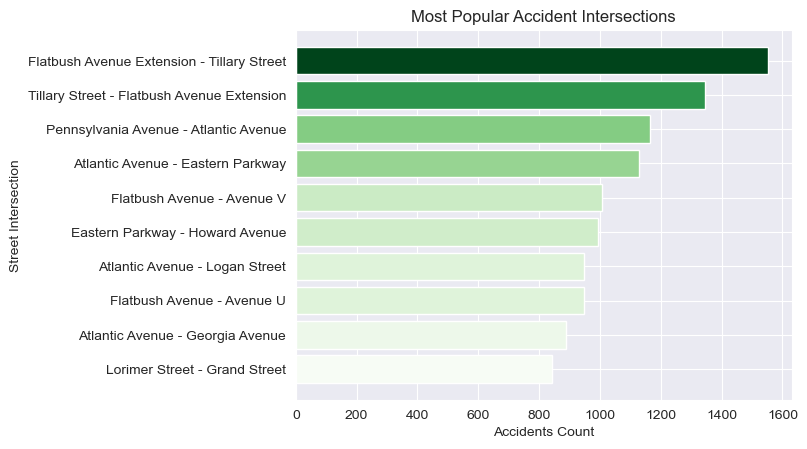

In [68]:
cmap = plt.get_cmap('Greens') 
normalize = plt.Normalize(min(top10.Count), max(top10.Count))

plt.barh(
    top10['on_street_name'] + " - " +  top10['cross_street_name'],
    top10['Count'], 
    color=cmap(normalize(top10.Count)), edgecolor='white'
    )
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])

plt.ylabel('Street Intersection')
plt.xlabel('Accidents Count')
plt.title('Most Popular Accident Intersections')
plt.gca().invert_yaxis()
plt.show()

**Time Series Analysis on Accidents**

2. Which time has the most accidents?
3. Which day of the week has the most accidents?

The timeframe of the dataset is between 2018 and 2023. 

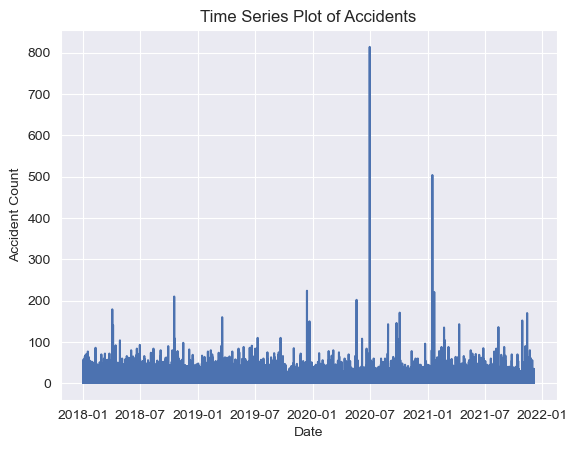

In [83]:
data = df.crash_datetime.value_counts().reset_index().rename(
    columns={'count':'Count'}
)

sns.lineplot(x='crash_datetime', y='Count', data=data)
plt.xlabel('Date')
plt.ylabel('Accident Count')
plt.title('Time Series Plot of Accidents')
plt.show()

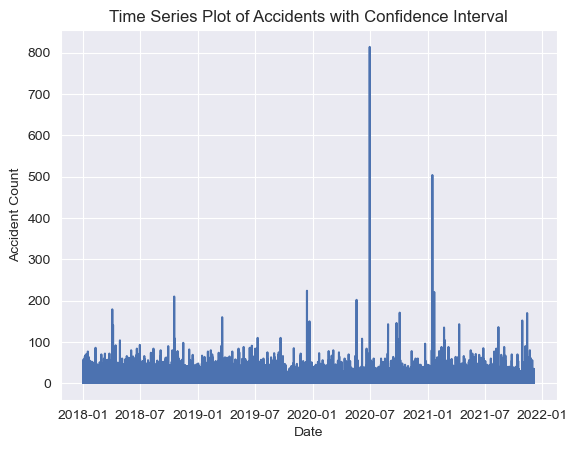

In [84]:
sns.lineplot(x='crash_datetime', y='Count', data=data, errorbar=('ci', 68))
plt.xlabel('Date')
plt.ylabel('Accident Count')
plt.title('Time Series Plot of Accidents with Confidence Interval')
plt.show()

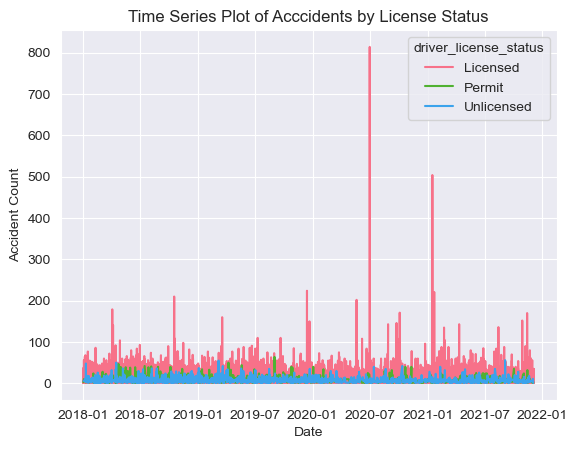

In [85]:
sns.lineplot(x='crash_datetime', y='Count', 
             hue=df.driver_license_status, data=data)
plt.xlabel('Date')
plt.ylabel('Accident Count')
plt.title('Time Series Plot of Acccidents by License Status')
plt.show()

In [101]:
df.set_index('crash_datetime').resample("M").mean()

KeyError: "None of ['crash_datetime'] are in the columns"

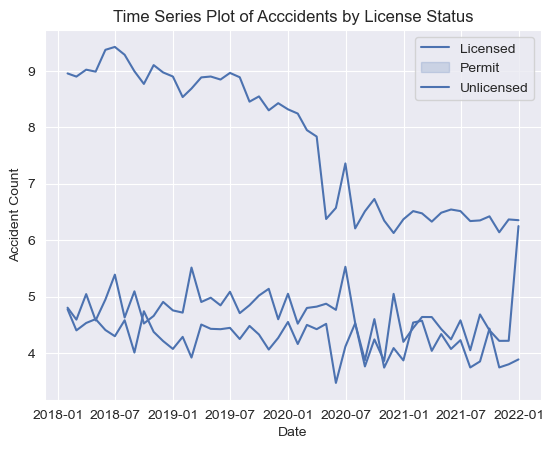

In [97]:
data = df.set_index('crash_datetime').resample("M").mean()

for category in df.driver_license_status.unique():
    sns.lineplot(
        x=data.index, 
        y=data[data["driver_license_status"] == category]["Value"], 
        label=category)


plt.xlabel('Date')
plt.ylabel('Accident Count')
plt.title('Time Series Plot of Acccidents by License Status')
plt.legend(labels=['Licensed', 'Permit', 'Unlicensed'])
plt.show()

In [92]:
li_monthly_mean

,crash_datetime,count
0,2018-01-31,8.952458
1,2018-02-28,8.896536
2,2018-03-31,9.019209
3,2018-04-30,8.984458
4,2018-05-31,9.370739
5,2018-06-30,9.421969
6,2018-07-31,9.282949
7,2018-08-31,8.991001
8,2018-09-30,8.766869
9,2018-10-31,9.100071



4. How many victims on average per accident?
5. Registration Year for cars in accidents.
6. Reasons for accidents.
7. For vehicles from x year, what is the likelihood of accidents?
8. Which street corner / intersection is prone to accidents?
9. Gender split for Accidents.
10. What are the most contributing factors for accidents.
11. Which vehicles contribute the most to accidents.
12. Accident Trends over time
13. Injured vs Killed stats
14. Relationship between Complainant and person injured
15. Vehicle Damage vs Vehicle Make, Vehicle Type, Registration Year, Driver Sex, Point of Impact and Travel Direction
16. Driver Licence jurisdictions and accidents
17. Understanding these features - Ejection, Emotional status, Bodily injury, Position in vehicle, Safety equipment, Ped role
18. Provide recommendations to reduce occurrence of accidents